# PySCF Interface

## Overview

The PySCF Interface module allows for direct extraction of Hamiltonian, overlap matrices, and density matrices from [PySCF](https://pyscf.org/) (Python simulations of chemistry framework) calculations into the DeepH format. 

[PySCF](https://pyscf.org/) is an open-source quantum chemistry software package designed primarily for (but not limit to) molecular systems. It features efficient implementations based on Gaussian-type atomic orbitals, providing a flexible and extensible platform for electronic structure calculations. Key functionalities include support for Hartree–Fock, post-Hartree–Fock methods (such as MP2, CCSD, and CASSCF), density functional theory (DFT), and real-time/time-dependent simulations. Its modular Python architecture allows for seamless integration with external libraries and custom workflows, making it well-suited for both standard molecular modeling and advanced methodological development.

Unlike the file-based conversion tools for [OpenMX](../../convert/openmx/demo.ipynb) or [SIESTA](../../convert/siesta/demo.ipynb), which process pre-computed output files, the PySCF interface is a **live Python API**. It integrates directly with PySCF's runtime, allowing you to extract Hamiltonian, overlap, and density matrices either in real-time during a calculation or directly from a completed mean-field object stored in memory.

This direct, programmatic approach offers key advantages:
-   **Streamlined Workflows:** It enables fully automated, script-based dataset generation pipelines without intermediate file parsing.
-   **Unified System Support:** The same interface works for both molecular systems (using Gaussian-type orbitals) and crystalline system using periodic boundary condition (PBC) calculations.
-   **Flexible Sampling:** It provides fine-grained control over k-point grids and other parameters during the data extraction process for generating tailored datasets.

**Note**: This compute module is designed for the latest PySCF version. Since PySCF is a Python library and not a standalone executable with standardized output files, this interface **does not support the command-line (CLI) `dock convert` workflow**. Instead, it provides a simple **Python Class API** `deepx_dock.compute.pyscf.pyscf_hooker.PySCFDataHooker`.

**Note:** This compute module is optimized for the latest stable version of PySCF. Because PySCF is fundamentally a Python library — not a standalone executable with fixed file outputs — this interface **cannot be used with the command-line like `deepx dock compute` and `deepx dock convert` tool**. All data extraction must instead be performed programmatically via the provided **Python Class API**.

## DFT Data File Structure

To use DeepH with PySCF data, your final dataset will be organized in the following standard format:

```bash
deeph_datasets/
├── H2O/
│   ├── info.json
│   ├── POSCAR
│   ├── hamiltonian.h5      # Exported by default
│   ├── overlap.h5          # Exported by default
│   └── density_matrix.h5   # Optional — requires export-rho=True
├── MgO/
│   └── ...
└── ...
```

**How this is achieved:**
Since PySCF does not natively support writing the Hamiltonian and overlap matrices directly to output files (it typically outputs density-related quantities to a checkpoint file via `mf.chkfile`), we cannot obtain these matrices by parsing standard output files.

Instead, an API call is integrated at the beginning or end of a single-point calculation. Once the computation finishes, the required physical quantities are read directly from memory and parsed into the standard DeepH data format shown above. For example, `hamiltonian.h5` and `overlap.h5` are exported by default, while `density_matrix.h5` is generated only when `export-rho=True` is set.

## Install DeepH-dock with PySCF Support

The PySCF interface offers a straightforward installation process, ideal for users who wish to quickly explore the [DeepH](https://arxiv.org/abs/2601.02938) algorithm but may be less familiar with setting up traditional computational software packages.

### Option 1: Install with PySCF included (recommended for quick start)
Run the following command to install DeepH-dock along with the PySCF optional dependency in one step:

```bash
pip install deepx-dock[pyscf]
```

### Option 2: Install separately
If you prefer to install PySCF separately or already have it configured, you can install DeepH-dock first:

```bash
pip install deepx-dock
```

Then install PySCF according to its [official installation guide](https://pyscf.org/user/install.html). To avoid compilation and ensure binary compatibility, it is recommended to use:

```bash
pip install --prefer-binary pyscf
```

## Key Features

1.  **Hook Mechanism**: Automatically collect data at the end of `mf.kernel()`.
2.  **Post-Calculation Dump**: Extract data from a converged mean-field object.
3.  **K-Point Interpolation**: Support exporting data on a denser k-point grid than used in the self-consistent calculation (via Wannier-like interpolation logic).
4.  **Overlap-Only Mode**: Rapidly generate overlap matrices for geometry-only tasks.

## Example: Extracting Hamiltonian for a Water Molecule

This section provides a step-by-step example of integrating a PySCF calculation with DeepH-dock to generate training data for a water (H$_2$O) molecule. The workflow demonstrates how to use the Python API to set up the molecular system, perform a self-consistent field (SCF) calculation, and extract the Hamiltonian and overlap matrices directly into the DeepH format.

**Key steps covered:**
1.  **Initialization**: Setting up the molecular structure and basis set using PySCF's `gto.M` and `dft.RKS` objects.
2.  **SCF Calculation & Data Extraction**: Performing an electronic structure calculation to obtain the converged mean-field object. At the same time, utilizing the `deepx_dock.compute.pyscf.pyscf_hooker.PySCFDataHooker` class to programmatically extract the Hamiltonian (`H`), overlap (`S`), and density matrices (`DM`) into the standardized DeepH data structure, bypassing any intermediate file generation.

For more details about how to use PySCF for DFT calcutiona process, please refer to its [offical documentation](https://pyscf.org/user/index.html).

See also [DeepH-dock PySCF `ipynb` examples](https://github.com/kYangLi/DeepH-dock/blob/main/examples/compute/pyscf/demo.ipynb).

### Step 1: Setup PySCF Calculation Parameters

In [1]:
# Example: Molecular H2O
from pathlib import Path
from pyscf import gto, dft

deeph_data_dir = Path('/tmp/deeph_data') # Path to the final store DeepH data

h2o_data_path = deeph_data_dir / "H2O"
# Define Molecule
mol = gto.M(
    atom='O 0.0 0.5 0.0; H -1.1 0.2 0.2; H 0.6 0.5 0.4',
    basis='cc-pvdz'
)
mol.verbose = 3
mol.spin = 0

# Define Mean-Field Object
mf = dft.RKS(mol)
mf.xc = 'b3lyp'

### Step 2: Perform PySCF Calculation Integrated with DeepH Hooker

The most straightforward way to use the interface is to wrap your PySCF mean-field object (`mf`) with `PySCFDataHooker` before running the calculation.

When you call `mf.kernel()`, the hook will:
1.  Run the standard PySCF calculation.
2.  Upon completion, automatically calculate and save the DeepH-formatted matrices to the specified directory.

**Parameters for `PySCFDataHooker`**:
-   `deeph_path` (str): Output directory.
-   `rcut` (float, optional): Global cutoff radius for local orbitals (in Angstrom).
    - if not provided, the default cutoff value from structure (`cell.rcut`) will be used.
    - **Note**: PySCF interface currently supports a single global `rcut` for all atoms.
-   `export_S` (bool): Export overlap matrix to `overlap.h5` (Default: True).
-   `export_H` (bool): Export Hamiltonian matrix to `hamiltonian.h5` (Default: True).
-   `export_rho` (bool): Export density matrix to `density.h5` (Default: False).

*Export position matrices not supported now.*

In [2]:
from deepx_dock.compute.pyscf.pyscf_hooker import PySCFDataHooker
# Apply the Hook
# - This "intercepts" the kernel call
mf = PySCFDataHooker(deeph_path=h2o_data_path, rcut=6.0)(mf)
# Run Calculation
# -Data will be saved to `/tmp/deeph_data/H2O` automatically
mf.kernel()
# Investigate the Data
print([str(v) for v in h2o_data_path.iterdir()])

Overwritten attributes  kernel  of <class 'pyscf.dft.rks.RKS'>
<class 'pyscf.dft.rks.RKS'> does not have attributes  is_hooked


converged SCF energy = -76.2699508748078
['/tmp/deeph_data/H2O/POSCAR', '/tmp/deeph_data/H2O/hamiltonian.h5', '/tmp/deeph_data/H2O/overlap.h5', '/tmp/deeph_data/H2O/info.json']


## Example: Extracting DeepH Data for MgO (Estimated: 15-30 minutes)

### Perform Main Calculation and Extract DeepH Data

In [3]:
# Example: Periodic MgO without spin (KRKS)
from pathlib import Path
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.dft as pbcdft
from ase.build import bulk

deeph_data_dir = Path('/tmp/deeph_data') # Path to the final store DeepH data
mgo_data_path = deeph_data_dir / 'MgO'

# Setup Cell
c = bulk('MgO', 'rocksalt', a=4.212)

cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(c)
cell.a = c.cell

cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade'
cell.verbose = 4
cell = cell.build(None,None)

In [4]:
from deepx_dock.compute.pyscf.pyscf_hooker import PySCFDataHooker
# Setup KRKS
kmf = pbcdft.KRKS(cell, cell.make_kpts([5,5,5]))
# Hook and Run
hooker = PySCFDataHooker(deeph_path=mgo_data_path, rcut=6.0)
kmf = hooker.hook_kernel(kmf)
kmf.kernel()
# Investigate the Data
print([str(v) for v in mgo_data_path.iterdir()])



******** <class 'pyscf.pbc.dft.krks.KRKS'> ********
method = KRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmp56exrmfj
max_memory 4000 MB (current use 206 MB)


******** PBC SCF flags ********
N kpts = 125
Exchange divergence treatment (exxdiv) = ewald
    madelung (= occupied orbital energy shift) = 0.11520439339185234
    Total energy shift due to Ewald probe charge = -1/2 * Nelec*madelung = -0.921635147135
DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7ad118ea6cf0>
XC functionals = LDA,VWN
small_rho_cutoff = 1e-07
Uniform grid, mesh = [135 135 135]
Set gradient conv threshold to 0.000316228


Overwritten attributes  kernel  of <class 'pyscf.pbc.dft.krks.KRKS'>
<class 'pyscf.pbc.dft.krks.KRKS'> does not have attributes  is_hooked


nelec by numeric integration = 16.000000000001997
init E= -79.6522794701871
HOMO = 0.177290764776  LUMO = 0.44501663384


/home/deeph/.uvenv/deeph-dock-dev/lib/python3.13/site-packages/pyscf/pbc/gto/cell.py:127: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


nelec by numeric integration = 15.99999999999999
cycle= 1 E= -79.0186729466853  delta_E= 0.634  |g|=  5.2  |ddm|= 26.3
HOMO = 0.609902339311  LUMO = 0.631029751344
nelec by numeric integration = 15.99999999999999
cycle= 2 E= -79.1029087769489  delta_E= -0.0842  |g|= 2.67  |ddm|=   30
HOMO = 0.449229455747  LUMO = 0.544716453298
nelec by numeric integration = 15.999999999999986
cycle= 3 E= -79.1349890737928  delta_E= -0.0321  |g|= 0.00684  |ddm|= 13.7
HOMO = 0.448532629836  LUMO = 0.543648049967
nelec by numeric integration = 15.999999999999986
cycle= 4 E= -79.1349891780533  delta_E= -1.04e-07  |g|= 0.000128  |ddm|= 0.0148
HOMO = 0.448534624018  LUMO = 0.543650241727
nelec by numeric integration = 15.999999999999986
cycle= 5 E= -79.1349891780751  delta_E= -2.18e-11  |g|= 2.33e-06  |ddm|= 0.000148
HOMO = 0.448534445058  LUMO = 0.543650170758
nelec by numeric integration = 15.999999999999988
Extra cycle  E= -79.1349891780751  delta_E= 1.42e-14  |g|= 1.34e-06  |ddm|= 1.53e-05
converged SCF

### Calculate and Plot Band Structure

Given the computationally intensive nature of MgO's SCF calculation, we utilize pre-computed PySCF data for direct band structure plotting in this section.

Warn: The original fermi energy (12.205243245980117) is not in the band gap (14.728295236126906, 12.205415834419272), and it will be modified into the band gap.


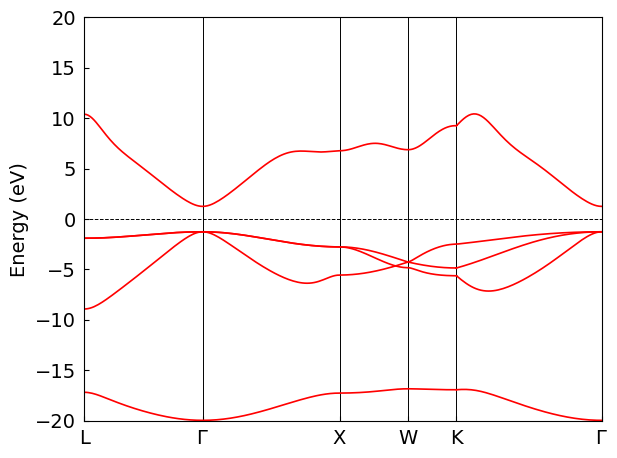

In [5]:
## Band Structure Calculation and Plotting
from pathlib import Path
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
from deepx_dock.compute.eigen.band import BandDataGenerator, BandPlotter

band_conf = {
    "k_list_spell" : """
    60   0.5  0.5  0.5    0.0  0.0  0.0    L     Gamma
    60   0.0  0.0  0.0    0.5  0.0  0.5    Gamma X
    60   0.5  0.0  0.5    0.5  0.25 0.75   X     W
    60   0.5  0.25 0.75   0.375 0.375 0.75 W     K
    60   0.375 0.375 0.75 0.0  0.0  0.0    K     Gamma
    """
}
finished_mgo_data_path = Path("./pyscf_deeph_data/MgO")
band_data_path = finished_mgo_data_path / "band_data.h5"
window = [-20, 20]

obj_H = HamiltonianObj(finished_mgo_data_path)
bd_gen = BandDataGenerator(obj_H, band_conf)
bd_gen.calc_band_data()
bd_gen.dump_band_data(band_data_path)
bd_plotter = BandPlotter(band_data_path)
bd_plotter.plot(*window)

## Example: Fast Approximate Extraction of DeepH Data for MgO (Estimated: 5-10 minutes)

Given the significant computational expense of self-consistent field (SCF) calculations, this section introduces a fast approximate approach to extract data without repeating the full SCF cycle. The `.dump()` method enables efficient post-processing by leveraging converged results for new k-point sets.

If you have already performed an SCF calculation, or if you wish to generate data on a **different k-point grid** than the one used for convergence, the `.dump()` method provides a computationally efficient alternative. This is particularly valuable for periodic systems where SCF may be run on a coarse grid (e.g., 2×2×2) for efficiency, while training data or detailed band structures require a denser grid (e.g., 5×5×5). By reusing the converged density matrix, this method avoids the costly iterative SCF procedure.

**Key Notes**:
- When applied to pre-computed results, `.dump()` approximates the exported quantities with computational cost comparable to a single SCF iteration, regardless of k-point sampling settings.
- For optimal efficiency:
  - If exporting on the **same** k-point grid as the original calculation, use `hook_kernel()` prior to the SCF run to embed data extraction directly.
  - If exporting on a **denser** k-point grid, use `.dump()` after convergence to avoid re-running SCF.

**Parameters for `hook_kernel()` and `dump()`**:
- `kpt` (list or tuple, optional): Specifies the k-point grid for data export. If omitted, the original k-points from the mean-field object are used.
  - Shape: `(3,)` for grid dimensions along reciprocal lattice vectors, or `(N_kpts, 3)` for explicit k-point coordinates in **1/Bohr** (e.g., as generated by `cell.make_kpts()`).

**Important Consideration on K-Points**:
- The `kpt` argument in `dump()` allows defining a target k-grid for evaluation.
- This constructs the Hamiltonian at new k-points using the converged density matrix, enabling rapid approximation without re-convergence.

In [6]:
from pathlib import Path
import pyscf.pbc.dft as pbcdft

deeph_data_dir = Path('/tmp/deeph_data') # Path to the final store DeepH data

# Run SCF on a coarse grid (2x2x2)
mgo_2_data_path = deeph_data_dir / 'MgO_2'
kmf = pbcdft.KRKS(cell, cell.make_kpts([2,2,2]))
kmf.kernel()
# Dump data on a DENSE grid (5x5x5)
# - Note: We initialize the hooker, but we call .dump() instead of wrapping the object
hooker = PySCFDataHooker(deeph_path=mgo_2_data_path, rcut=6.0)
# The 'kpt' argument defines the target grid (can be denser than SCF k-grid)
hooker.dump(kmf, kpt=[5,5,5])
# Investigate the Data
print([str(v) for v in mgo_data_path.iterdir()])



******** <class 'pyscf.pbc.dft.krks.KRKS'> ********
method = KRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpe3np688f
max_memory 4000 MB (current use 434 MB)


******** PBC SCF flags ********
N kpts = 8
Exchange divergence treatment (exxdiv) = ewald
    madelung (= occupied orbital energy shift) = 0.28801098347963133
    Total energy shift due to Ewald probe charge = -1/2 * Nelec*madelung = -2.30408786784
DF object = <pyscf.pbc.df.fft.FFTDF object at 0x7ad100387c50>
XC functionals = LDA,VWN
small_rho_cutoff = 1e-07
Uniform grid, mesh = [135 135 135]
Set gradient conv threshold to 0.000316228
nelec by numeric integration = 15.999999999998318
init E= -79.626555756979
HOMO = 0.165678347217  LUMO = 0.438933853866


/home/deeph/.uvenv/deeph-dock-dev/lib/python3.13/site-packages/pyscf/pbc/gto/cell.py:127: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


nelec by numeric integration = 15.999999999999135
cycle= 1 E= -78.9639790692052  delta_E= 0.663  |g|=  1.3  |ddm|= 6.71
HOMO = 0.637386704152  LUMO = 0.648391862796
nelec by numeric integration = 15.999999999999115
cycle= 2 E= -79.0578578474477  delta_E= -0.0939  |g|= 0.479  |ddm|=    5
HOMO = 0.503425598837  LUMO = 0.5714277415
nelec by numeric integration = 15.999999999999105
cycle= 3 E= -79.0718358428109  delta_E= -0.014  |g|= 0.00422  |ddm|=  1.6
HOMO = 0.501825006552  LUMO = 0.570157021869
nelec by numeric integration = 15.999999999999103
cycle= 4 E= -79.0718368767775  delta_E= -1.03e-06  |g|= 4.12e-05  |ddm|= 0.0132
HOMO = 0.501818193527  LUMO = 0.57015373545
nelec by numeric integration = 15.999999999999101
cycle= 5 E= -79.0718368768439  delta_E= -6.64e-11  |g|= 6.92e-07  |ddm|= 9.39e-05
HOMO = 0.501817943149  LUMO = 0.570153609338
nelec by numeric integration = 15.999999999999101
Extra cycle  E= -79.0718368768439  delta_E= -2.84e-14  |g|= 2.53e-07  |ddm|= 2.91e-06
converged SCF

### Calculate and Plot Band Structure

Given the computationally intensive nature of MgO's SCF calculation, we also use pre-computed PySCF data to plot the band structure directly in this section. The resulting band structure is identical to the one obtained in the previous section, confirming the success of our efficient post‑processing method using dump and custom k‑points.

Warn: The original fermi energy (13.655161000039902) is not in the band gap (15.451583257116503, 13.655340410901543), and it will be modified into the band gap.


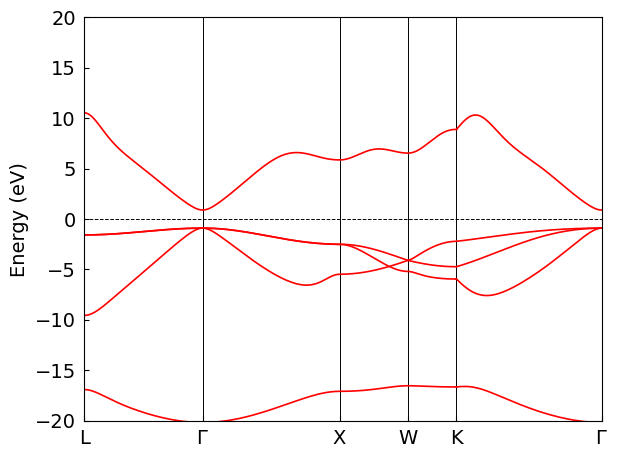

In [7]:
## Band Structure Calculation and Plotting
from pathlib import Path
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
from deepx_dock.compute.eigen.band import BandDataGenerator, BandPlotter

band_conf = {
    "k_list_spell" : """
    60   0.5  0.5  0.5    0.0  0.0  0.0    L     Gamma
    60   0.0  0.0  0.0    0.5  0.0  0.5    Gamma X
    60   0.5  0.0  0.5    0.5  0.25 0.75   X     W
    60   0.5  0.25 0.75   0.375 0.375 0.75 W     K
    60   0.375 0.375 0.75 0.0  0.0  0.0    K     Gamma
    """
}
finished_mgo_data_path = Path("./pyscf_deeph_data/MgO_2")
band_data_path = finished_mgo_data_path / "band_data.h5"
window = [-20, 20]

obj_H = HamiltonianObj(finished_mgo_data_path)
bd_gen = BandDataGenerator(obj_H, band_conf)
bd_gen.calc_band_data()
bd_gen.dump_band_data(band_data_path)
bd_plotter = BandPlotter(band_data_path)
bd_plotter.plot(*window)

## Example: Calculate the Overlap Matrix Only for MgO

For some workflows (like constructing graph structures before electronic iterations or after inference of hamiltonians using machine learning models), you may only need the overlap matrix. The `dump_ovlp` method is optimized for this and skips Hamiltonian construction.

The parameters are similar to the full dump method, but only the overlap matrix is computed and saved.

In [8]:
# Export ONLY the overlap matrix
deeph_data_dir = Path('/tmp/deeph_data') # Path to the final store DeepH data

output_path_ovlp = deeph_data_dir / 'MgO_2_overlap'
hooker_ovlp = PySCFDataHooker(deeph_path=output_path_ovlp, rcut=6.0)

# dump_ovlp can also accept a custom k-point grid
# Note: This runs very fast as it only loops over overlaps
hooker_ovlp.dump_ovlp(kmf, kpt=[5,5,5])

print(f"Overlap data generated at: {output_path_ovlp}")

Overlap data generated at: /tmp/deeph_data/MgO_2_overlap


In [9]:
from pathlib import Path
print([str(v) for v in list(Path("/tmp/deeph_data").iterdir())])
print([str(v) for v in list(Path("/tmp/deeph_data/MgO").iterdir())])

['/tmp/deeph_data/GaAs_SOC', '/tmp/deeph_data/H2O_U', '/tmp/deeph_data/H2O', '/tmp/deeph_data/MgO_2', '/tmp/deeph_data/MoS2', '/tmp/deeph_data/MgO', '/tmp/deeph_data/MoTe2', '/tmp/deeph_data/Si', '/tmp/deeph_data/MgO_2_overlap', '/tmp/deeph_data/Bi2Se3_SOC']
['/tmp/deeph_data/MgO/POSCAR', '/tmp/deeph_data/MgO/hamiltonian.h5', '/tmp/deeph_data/MgO/overlap.h5', '/tmp/deeph_data/MgO/info.json']


## Important Considerations

### Global Cutoff Radius (`rcut`)
The `rcut` parameter in `PySCFDataHooker` defines the cutoff radius for determining the sparsity pattern of the Hamiltonian and overlap matrices (i.e., which atom pairs effectively interact).
*   **Current Limit**: Only a single global `rcut` is supported for all atom pairs.
*   Make sure `rcut` is large enough for your basis set convergence but small enough to maintain sparsity.

### K-Point Density
When exporting periodic data, you can specify a target `kpt` grid (e.g., `[5,5,5]`) that is distinct from the SCF mesh. This is useful for dataset generation.
*   **Density Warning**: If your target grid is significantly denser than what `rcut` can support (based on Shannon sampling theorem/Wannier interpolation limits), you may see warnings or artifacts.
*   Usually, `k_grid` density and `rcut` should be physically consistent with the localization of your basis functions.

### No Command Line Interface
As demonstrated, this module is strictly a Python API. There is no `dock compute pyscf ...` or `dock convert pyscf ...` command because PySCF inputs are Python scripts themselves. Integration involves importing `PySCFDataHooker` directly into your calculation scripts.

---

*This compute module represents a key component in bridging dynamic quantum chemical simulations with modern machine learning approaches in materials science, enabling researchers to leverage the Python-native flexibility of PySCF for automated dataset generation in cutting-edge machine learning applications.*